In [1]:
import sys, os, glob, warnings, logging
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest
from sw_qPCR import *

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
# Read in data from different plates and combine them
plate_ids = ['220606-plate1', '220606-plate2', '220606-plate3',
             '220627-plate3', '220627-plate4', '220627-plate5']
dfs = []
for plate_id in plate_ids:
    dfs.append(get_plate_data(plate_id))

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)

# Add a few helpful columns
df['group'] = [df.Sample[i] + '___' + df.Primer[i] for i in range(len(df))]
df['well_id'] = [df.plate_id[i] + '-' + df.Well[i] for i in range(len(df))]
df['relExp_25'] = [2**(25-df.Cq[i]) for i in range(len(df))]

df.head()

,Well,Sample,Primer,Cq,plate_id,sgRNA_id,group,well_id,relExp_25
0,A01,B-188-1,Rps29 v1,22.184486,220606-plate1,188,B-188-1___Rps29 v1,220606-plate1-A01,7.039699
1,A02,B-188-1,Rps29 v1,22.106597,220606-plate1,188,B-188-1___Rps29 v1,220606-plate1-A02,7.430209
2,A03,B-188-1,Rps29 v1,21.971934,220606-plate1,188,B-188-1___Rps29 v1,220606-plate1-A03,8.157153
3,A04,B-317-1,Rps29 v1,21.709593,220606-plate1,317,B-317-1___Rps29 v1,220606-plate1-A04,9.783881
4,A05,B-317-1,Rps29 v1,21.603098,220606-plate1,317,B-317-1___Rps29 v1,220606-plate1-A05,10.533422


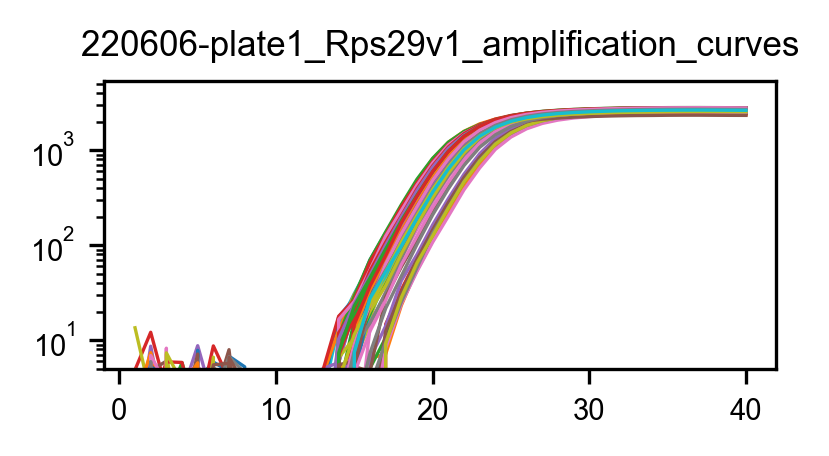

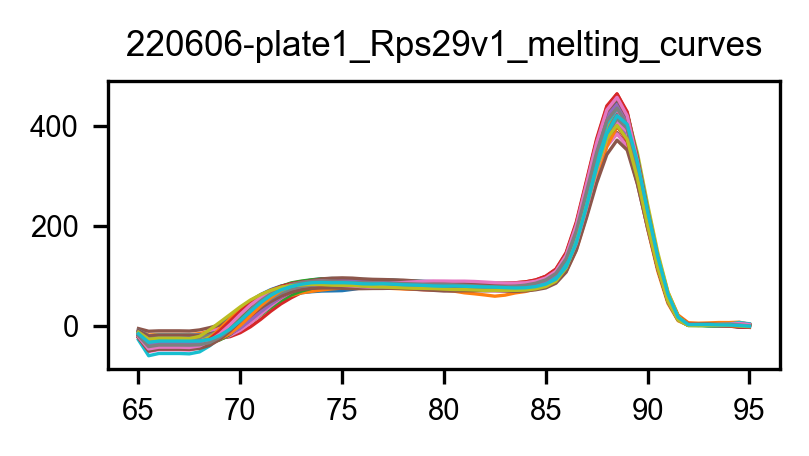

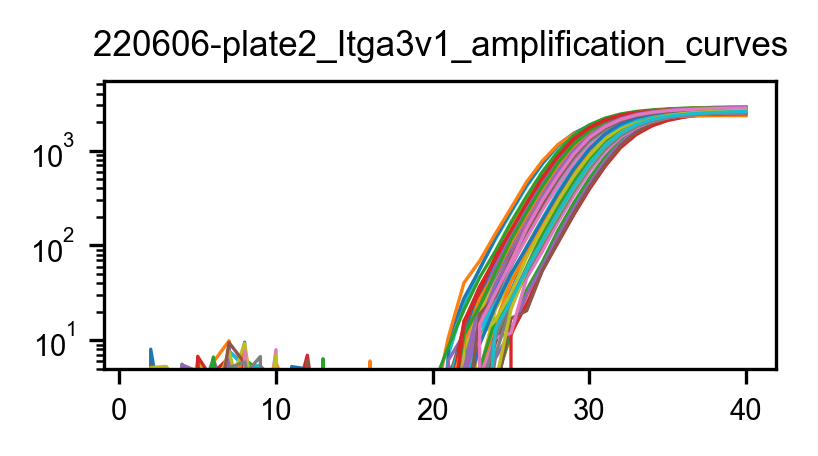

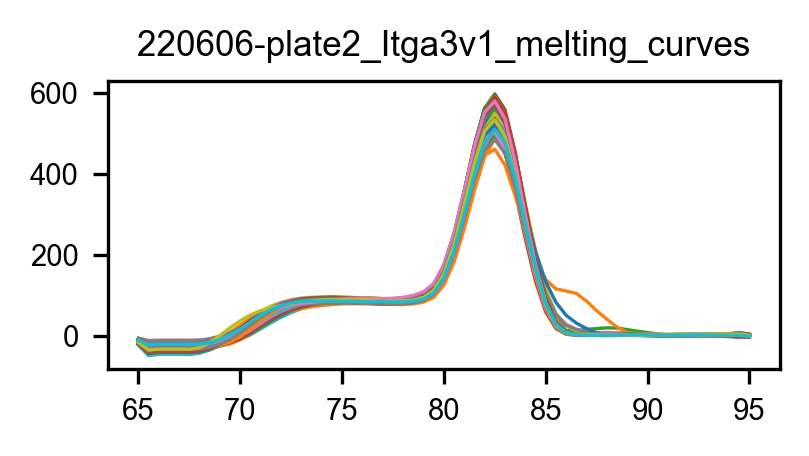

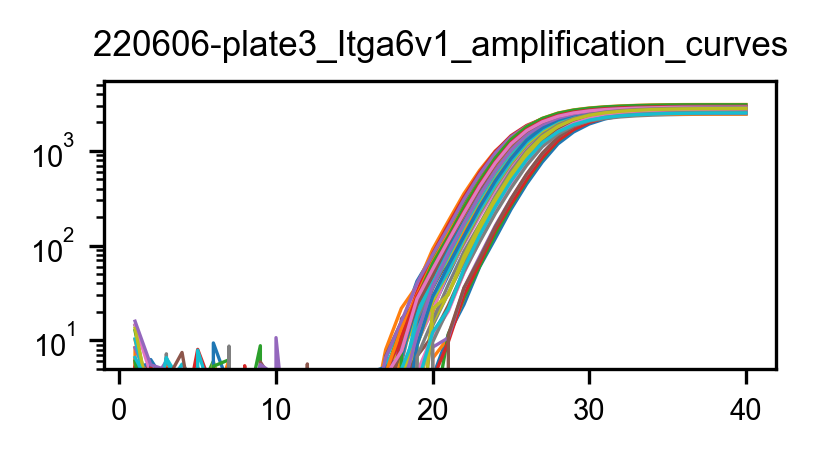

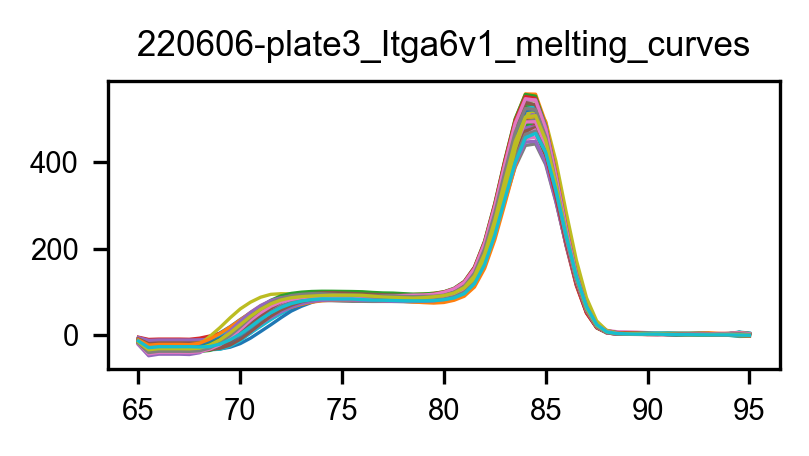

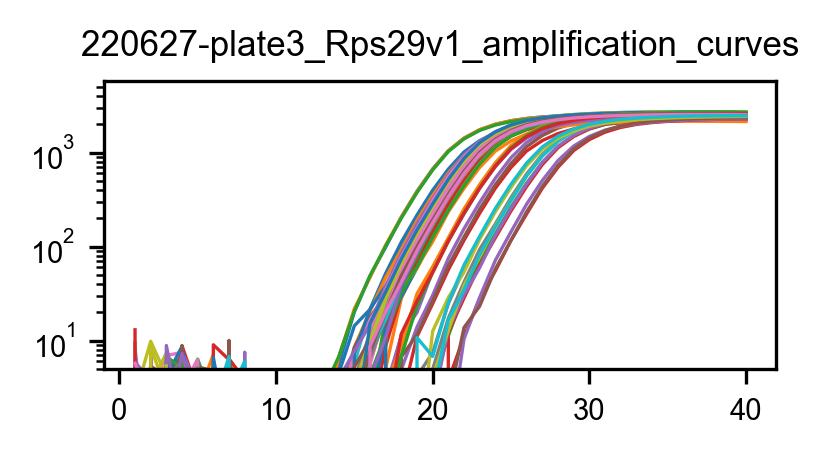

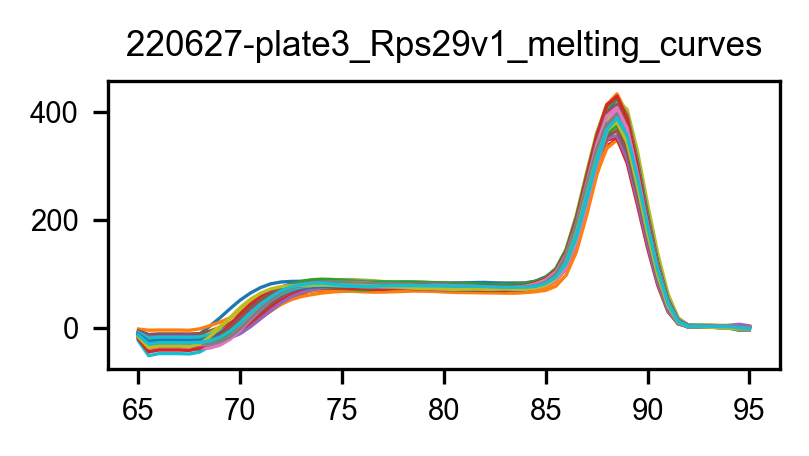

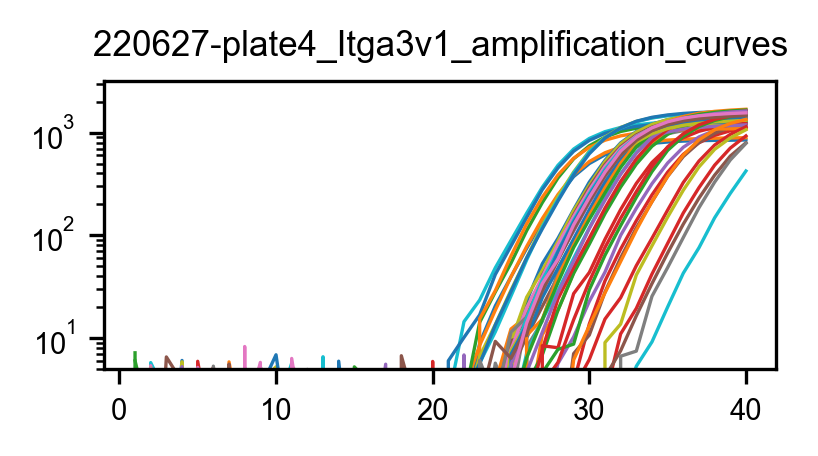

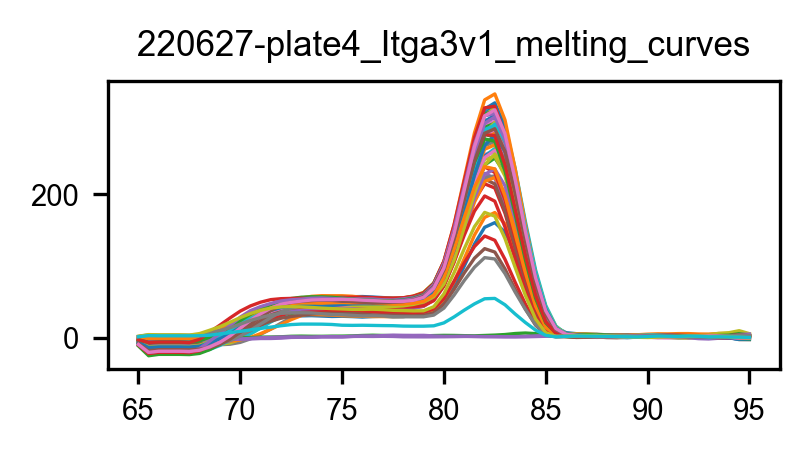

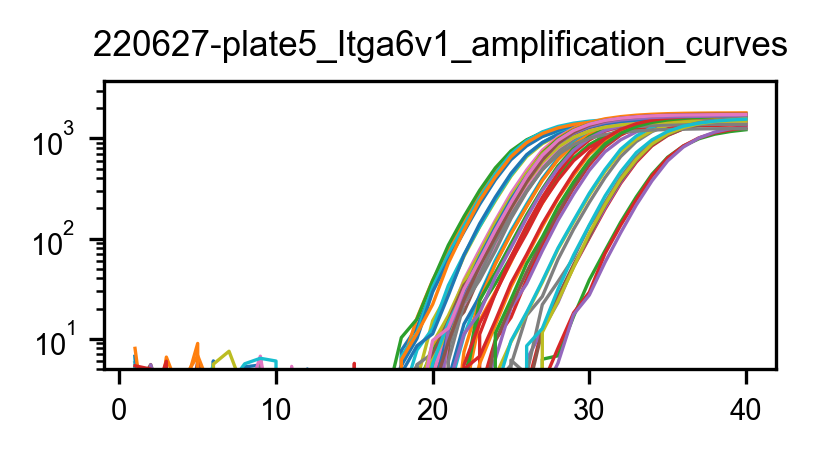

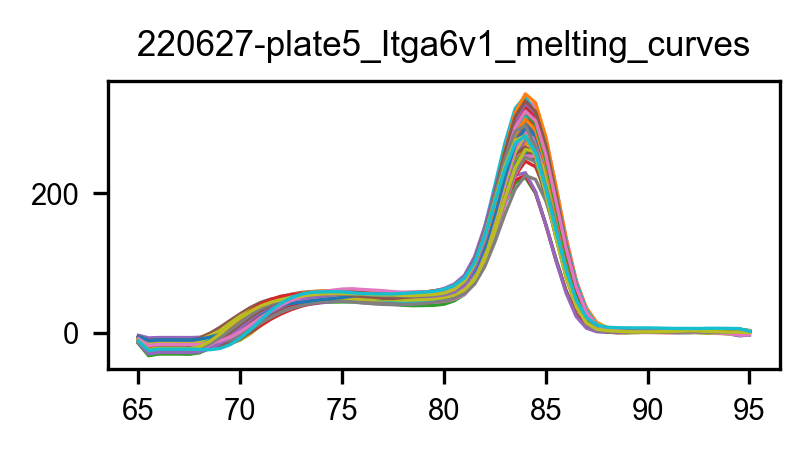

In [3]:
# Insepct the amplification and melting curves of each plate per primer to check
# if there are problematic data that should be excluded
primers = ['Rps29 v1', 'Itga3 v1', 'Itga6 v1']
for plate_id in plate_ids:
#     df_annotation = get_annotation_data(plate_id)
    # for primer in df_annotation.Primer.unique():
    for primer in primers:
        plot_amplification_curves(plate_id, primer, ymax=None)
        plot_melting_curves(plate_id, primer)

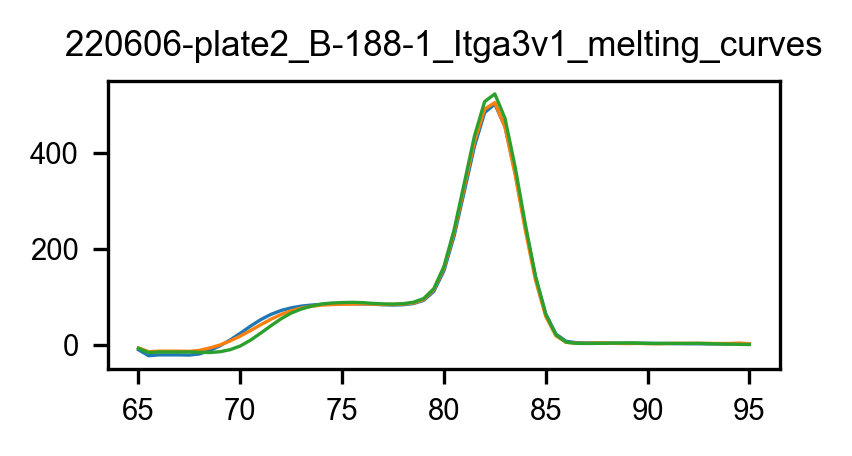

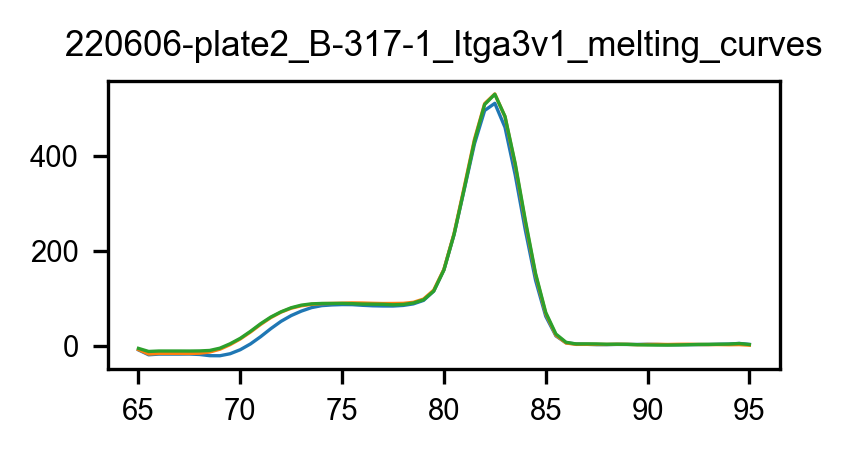

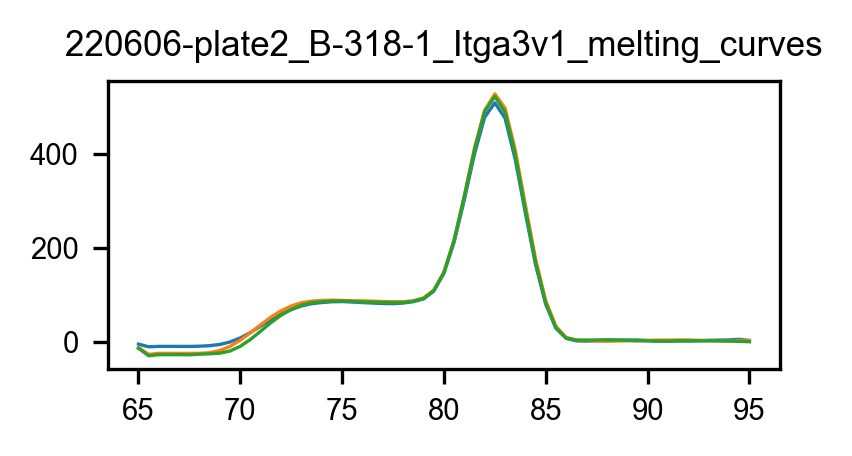

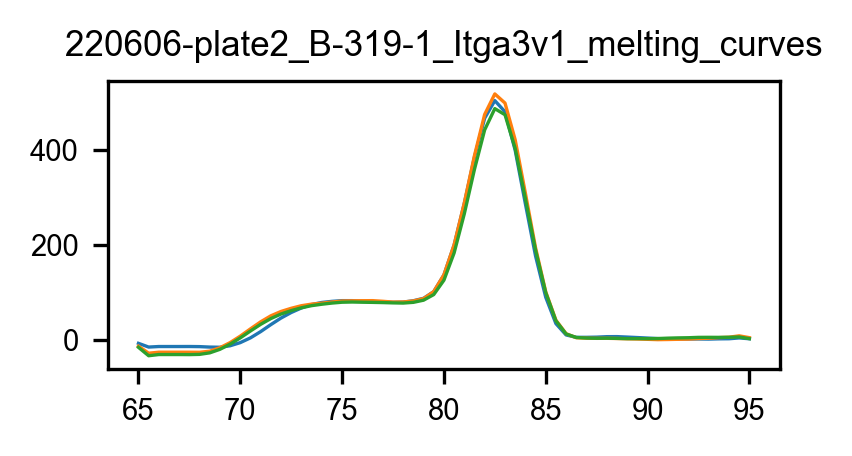

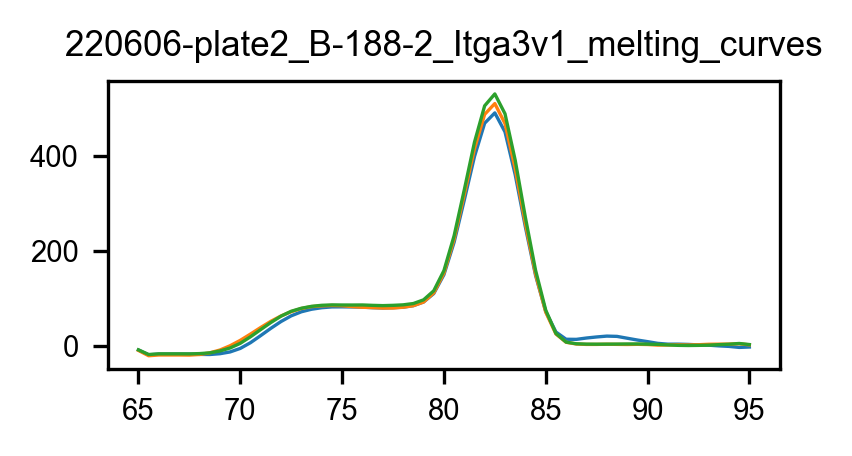

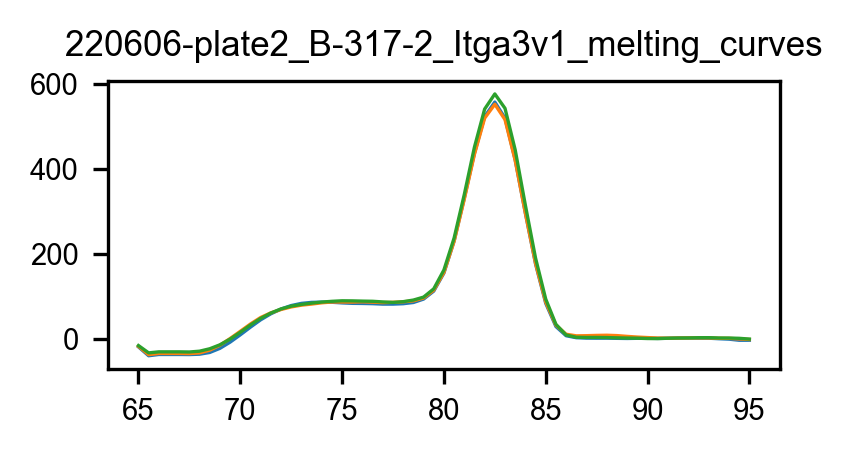

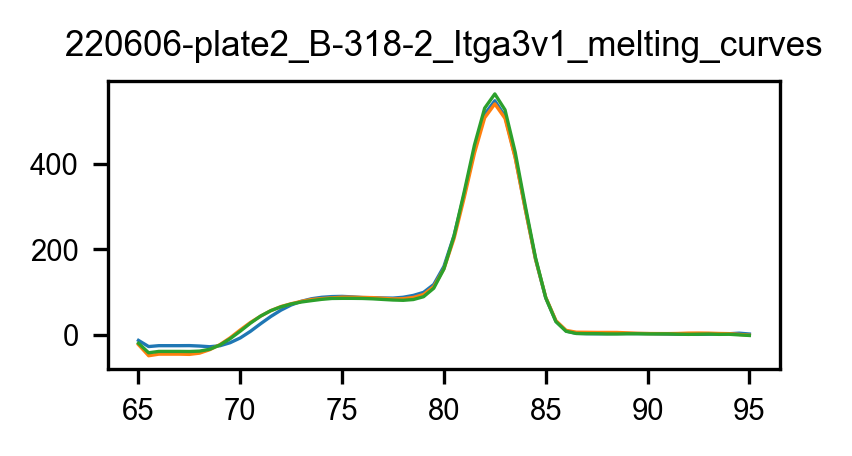

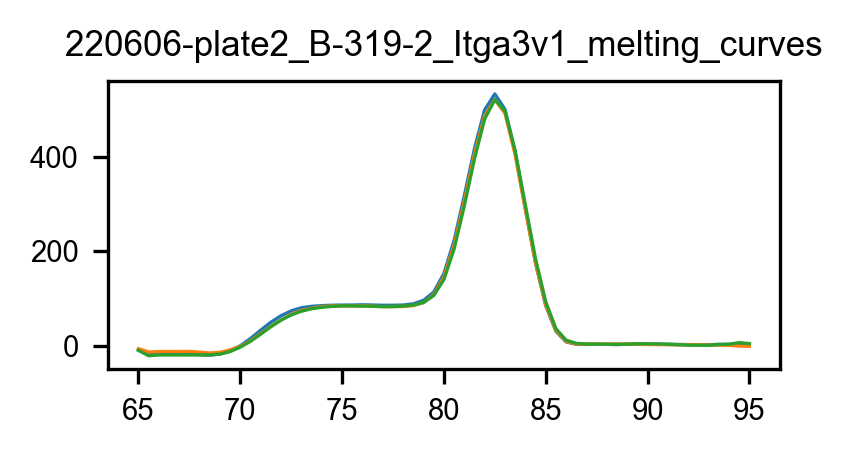

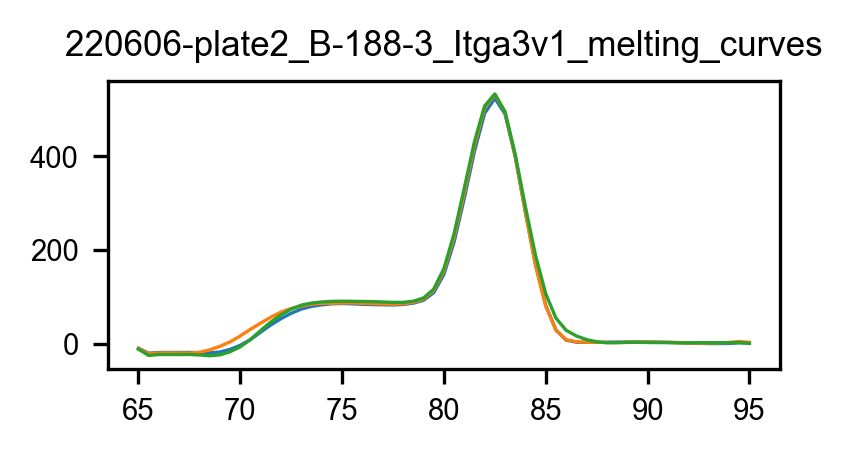

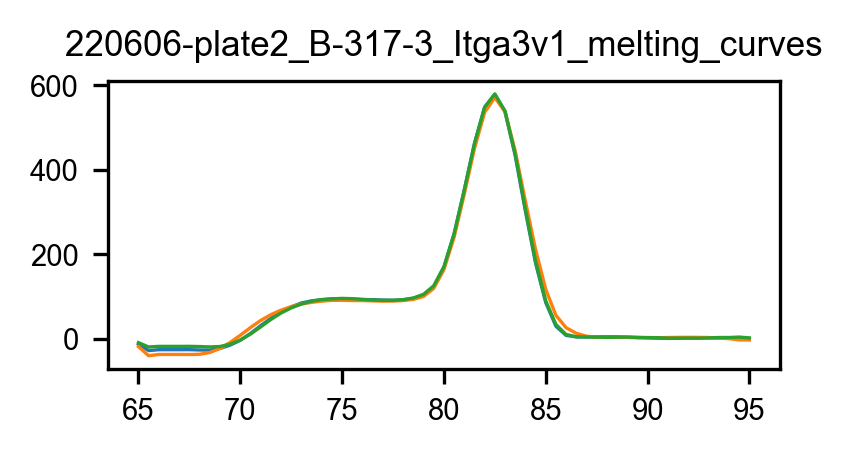

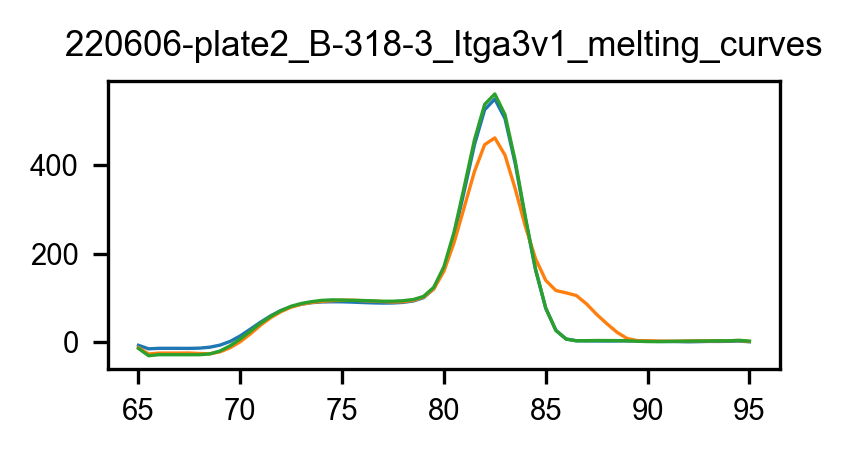

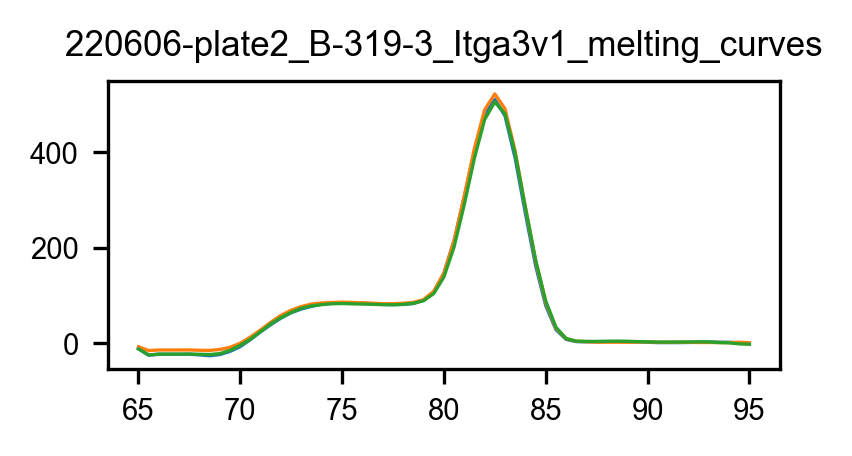

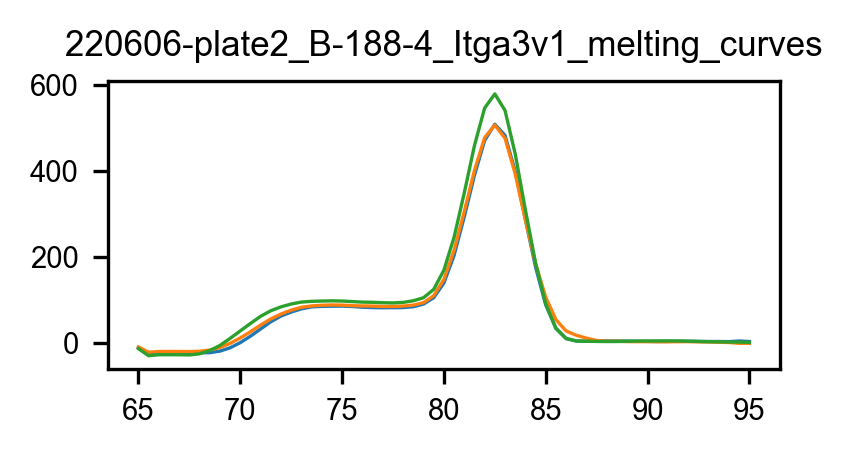

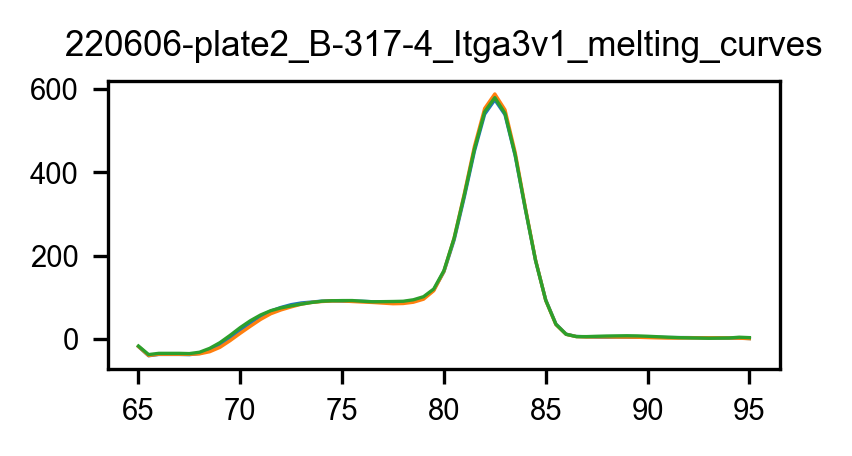

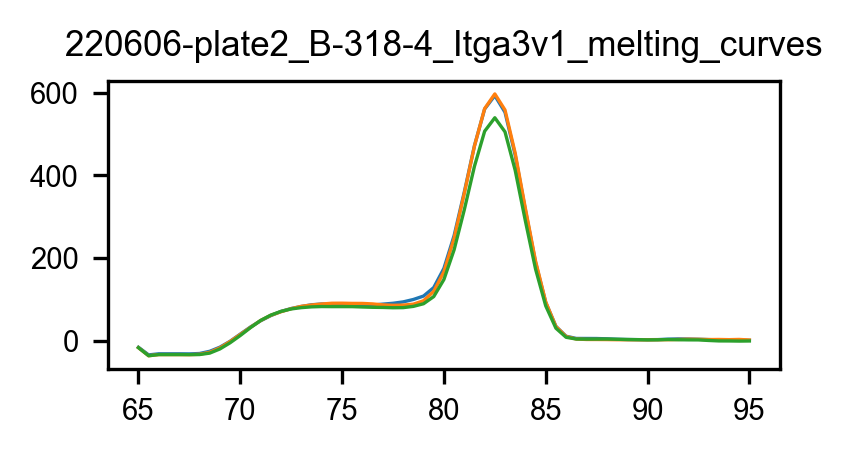

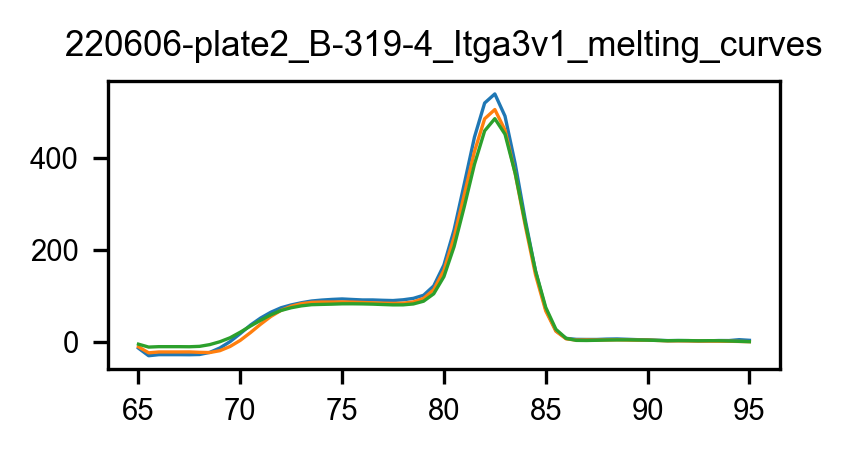

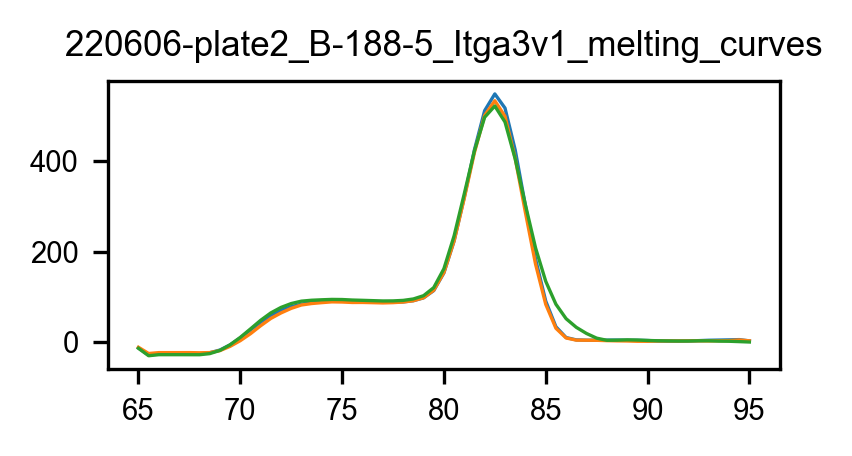

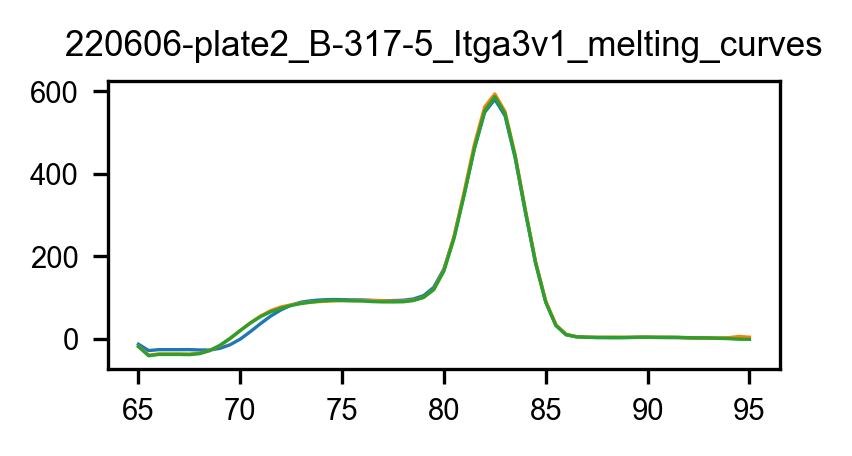

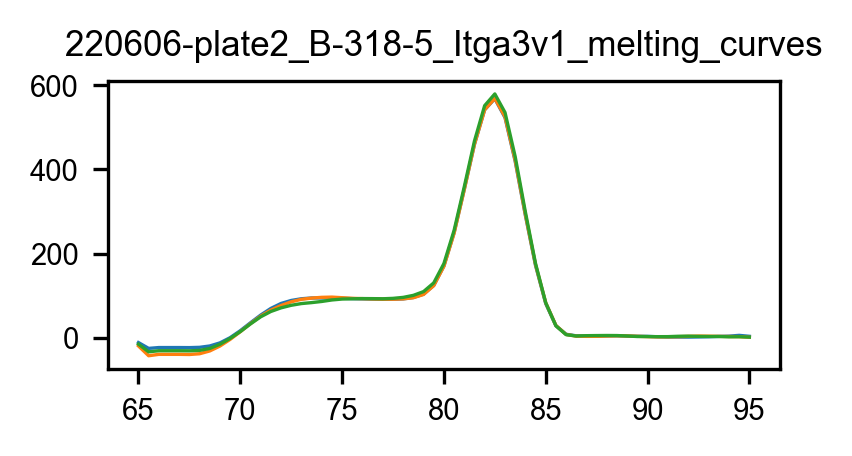

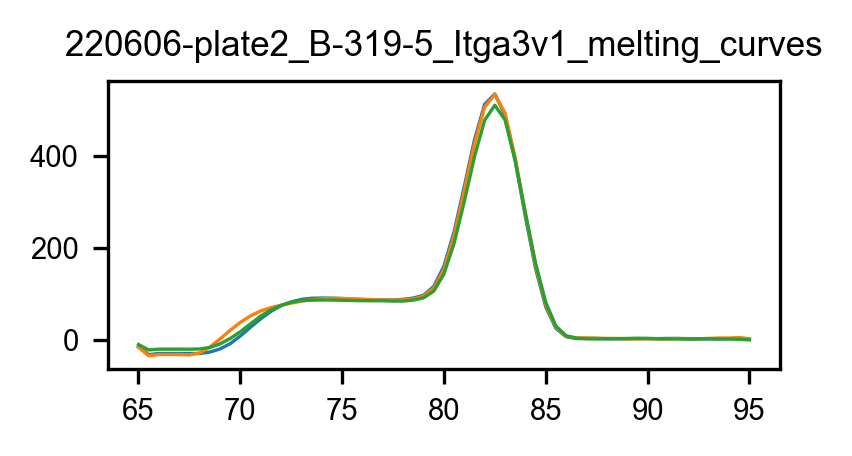

In [4]:
plate_id = '220606-plate2'
primer = 'Itga3 v1'
df_annotation = get_annotation_data(plate_id)
for sample in df_annotation.Sample.unique():
    plot_melting_curves(plate_id, primer, sample=sample, save_fig=False)

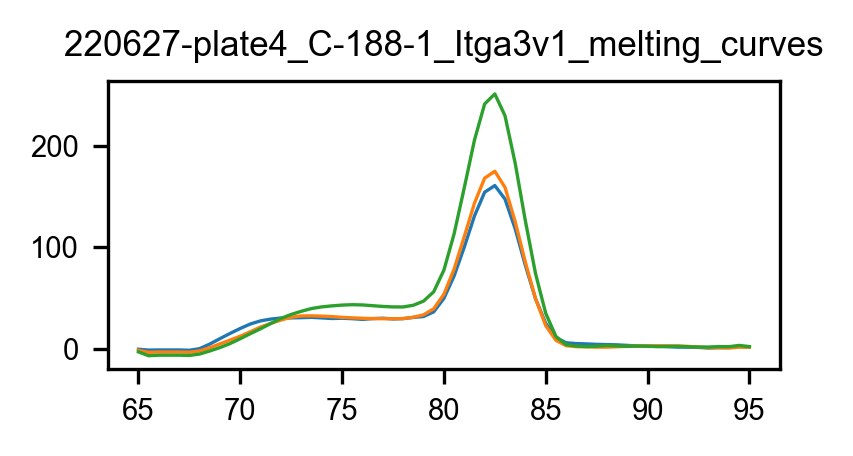

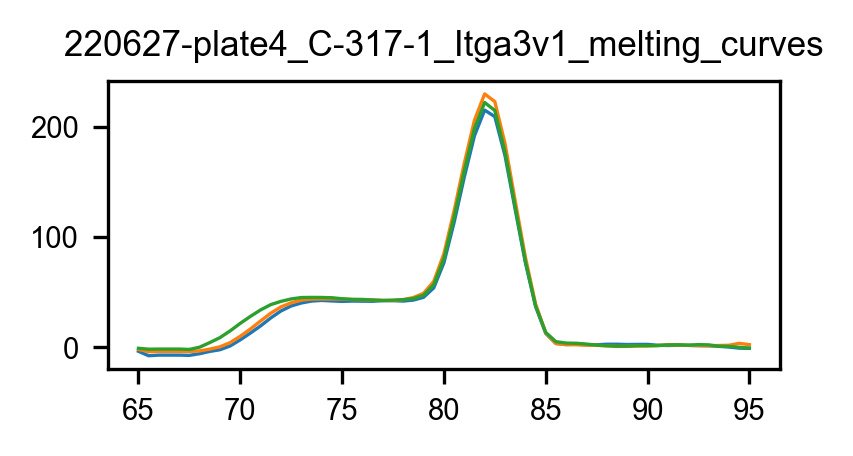

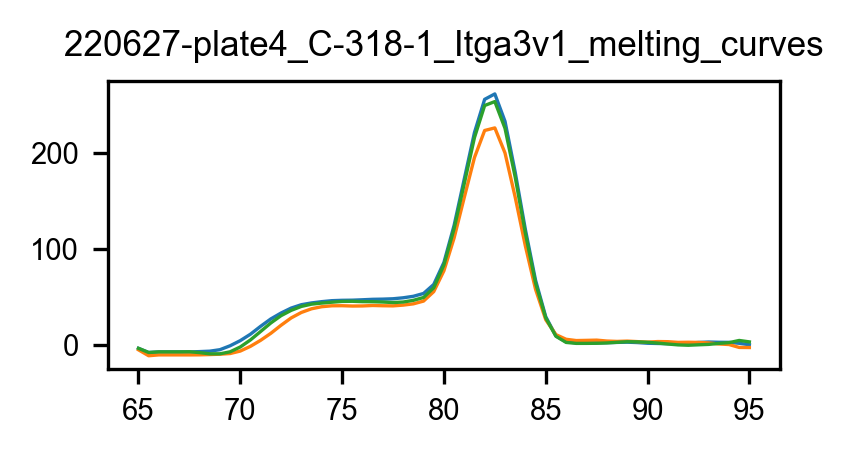

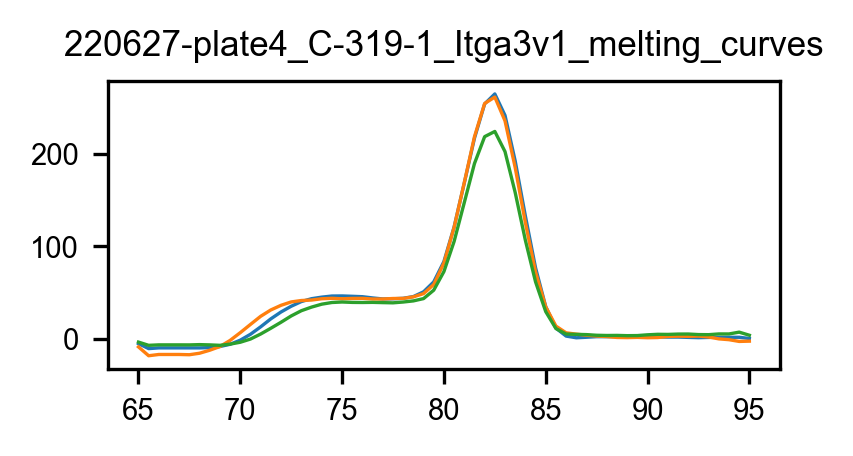

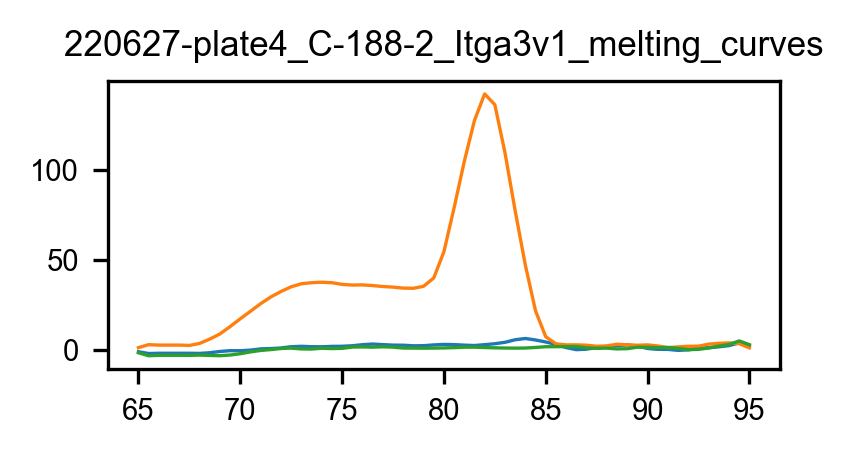

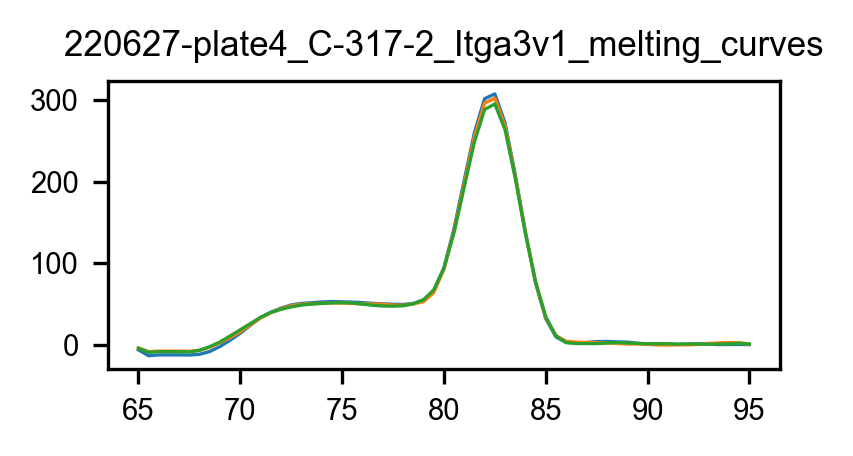

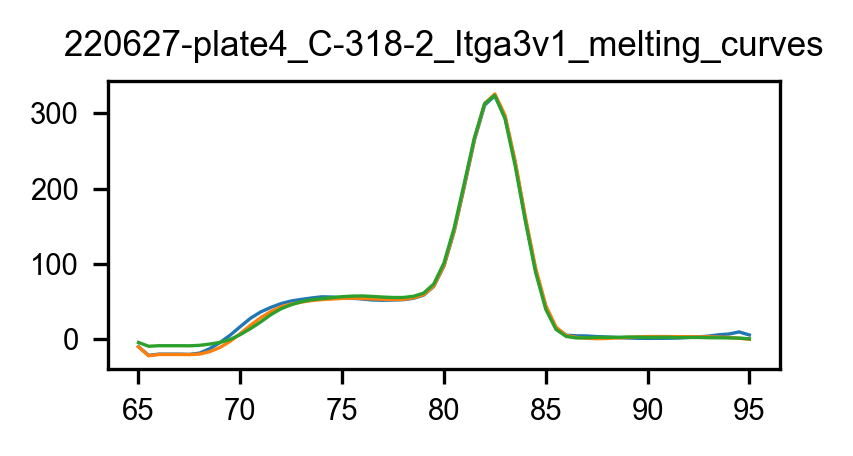

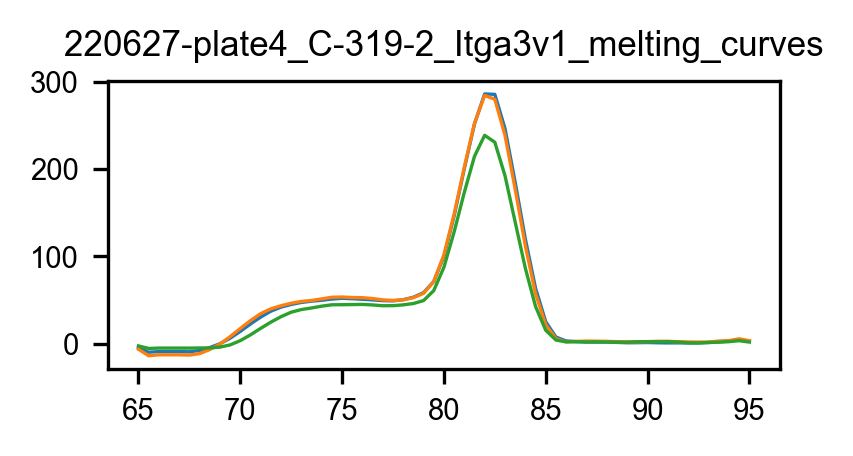

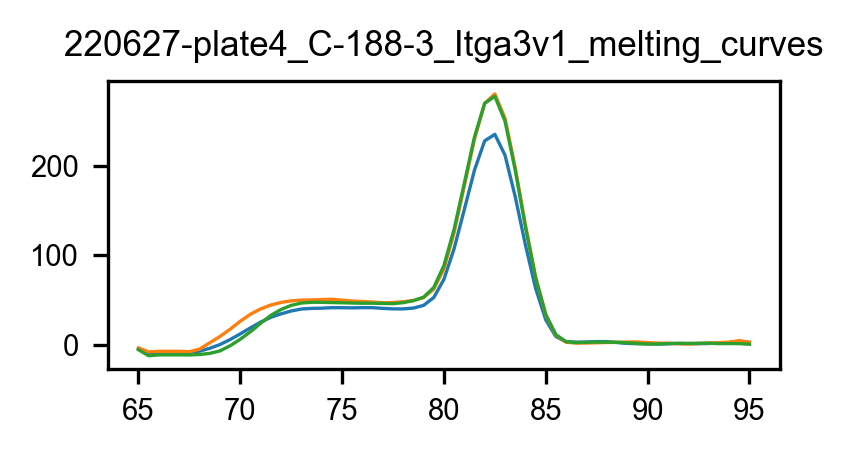

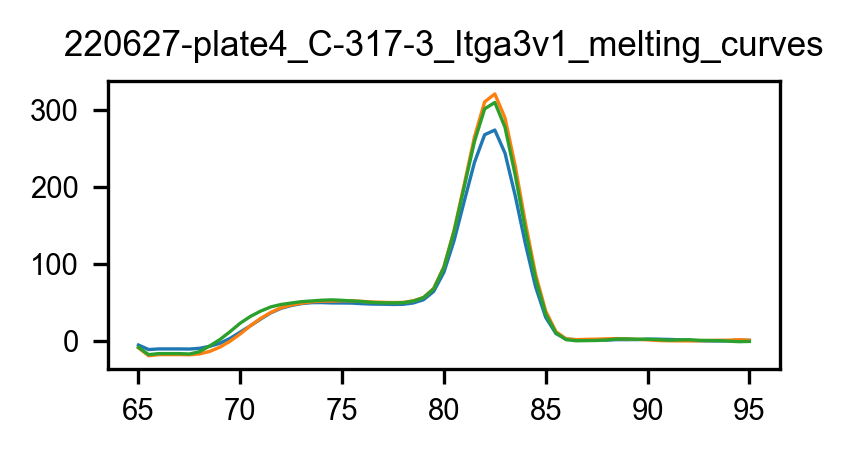

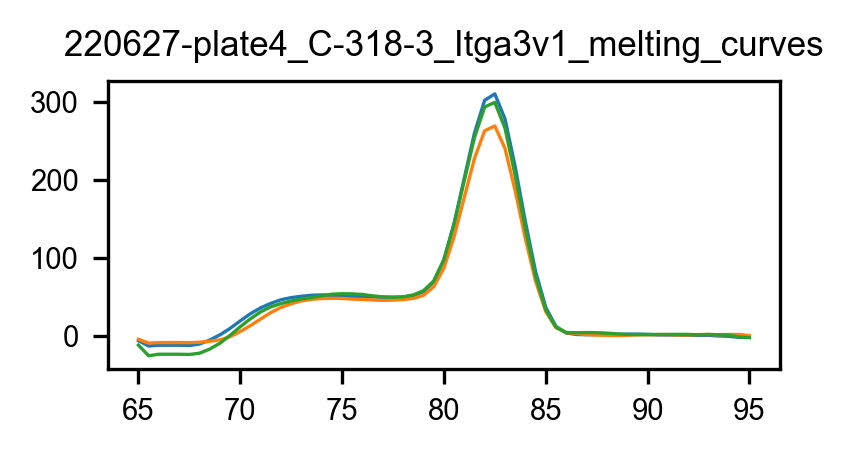

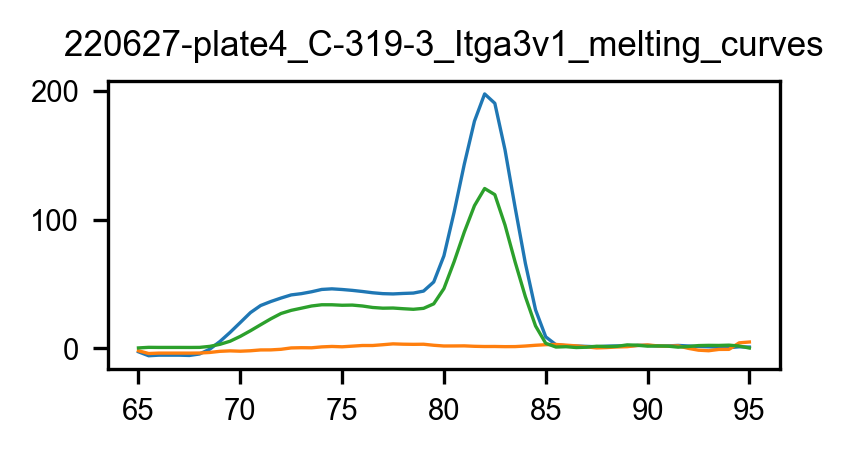

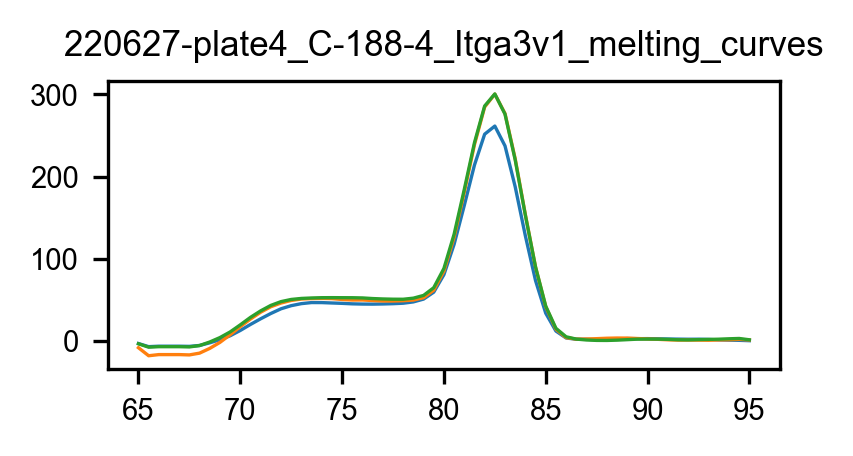

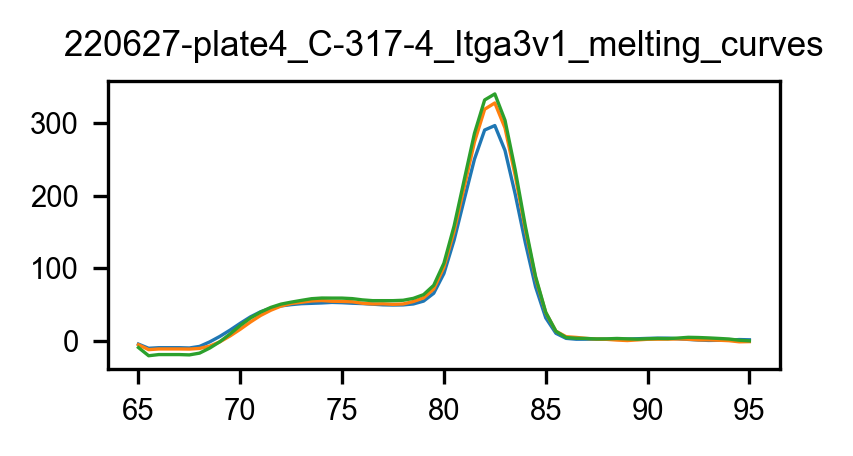

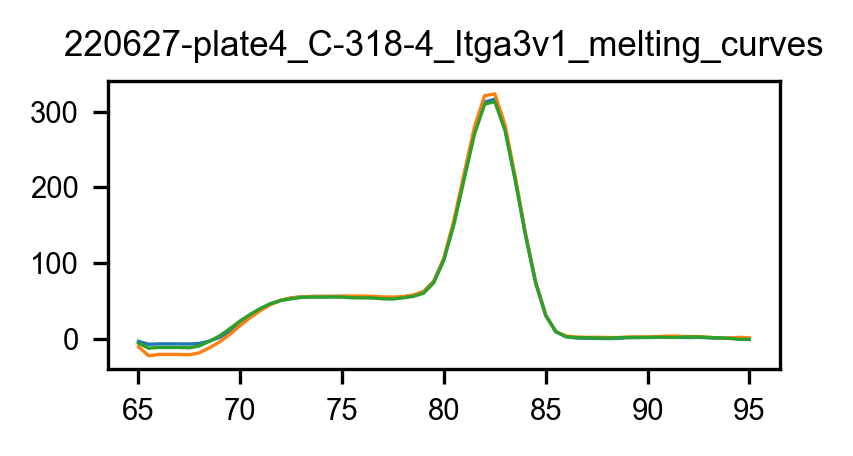

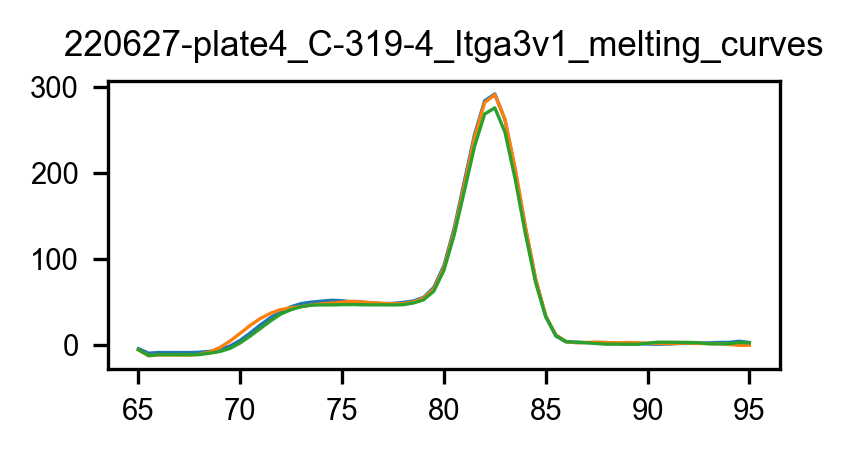

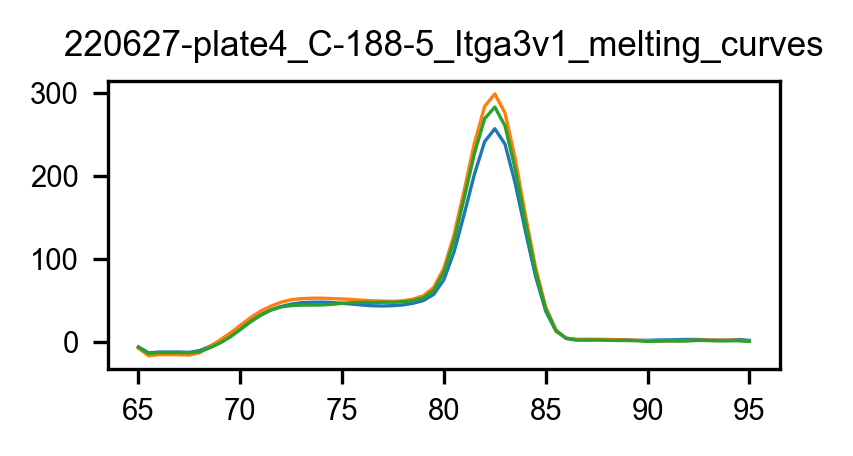

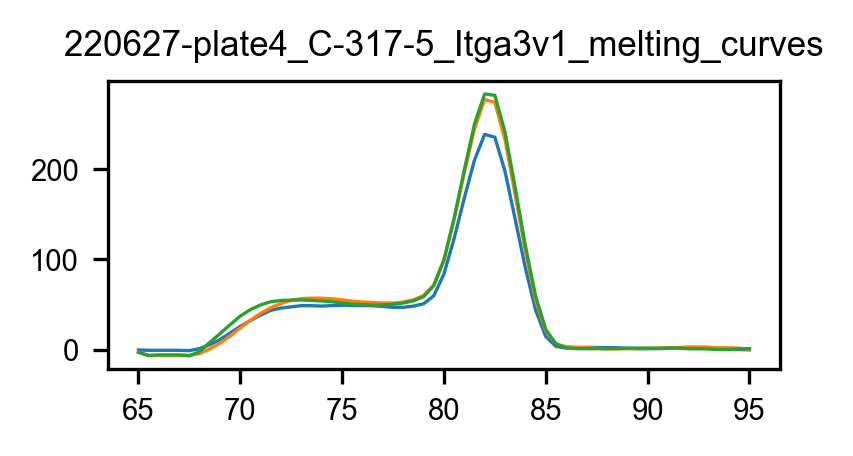

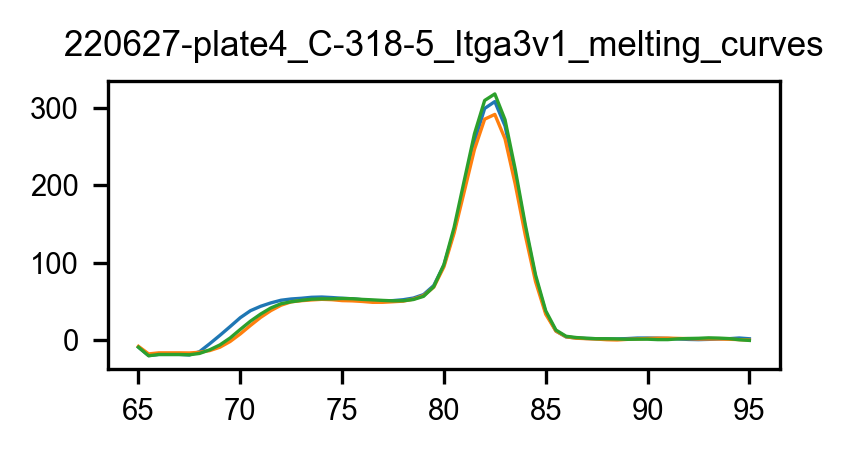

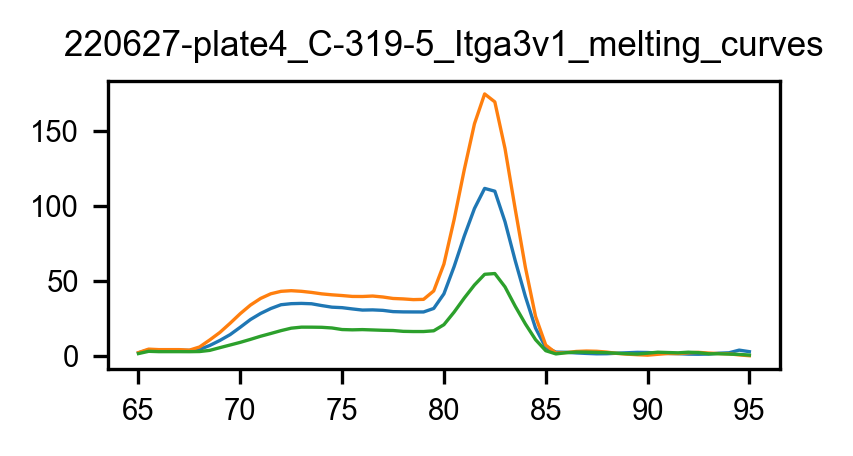

In [5]:
plate_id = '220627-plate4'
primer = 'Itga3 v1'
df_annotation = get_annotation_data(plate_id)
for sample in df_annotation.Sample.unique():
    plot_melting_curves(plate_id, primer, sample=sample, save_fig=False)

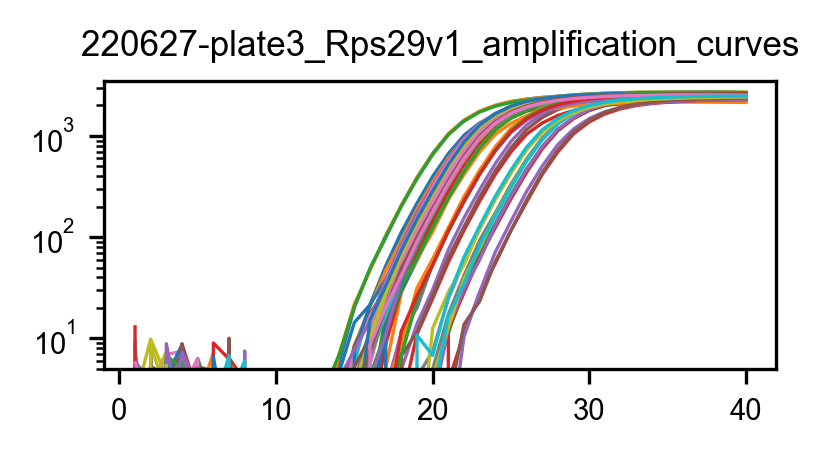

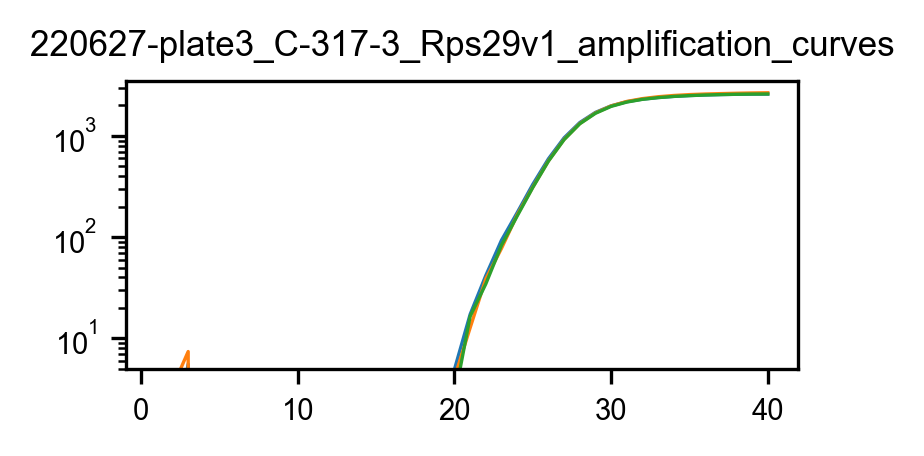

In [6]:
plate_id = '220627-plate3'
primer = 'Rps29 v1'
df_annotation = get_annotation_data(plate_id)
for sample in ['C-317-3']:
    plot_amplification_curves(plate_id, primer, save_fig=False)
    plot_amplification_curves(plate_id, primer, sample=sample, save_fig=False)

In [7]:
# By inspecting the curves above, curate a list of samples to exclude
# C-317-3 has a Cq of reference (Rps29) beyond 25, so it is removed
samples_to_exclude = ['C-188-2', 'C-317-3']
# samples_to_exclude = ['B-318-3', 'C-188-2', 'C-319-3'] # have at least 2 good ones, so rely on outlier removal

df = df[~df.Sample.isin(samples_to_exclude)]
df.reset_index(drop=True, inplace=True)

In [8]:
df.shape

(341, 9)

In [9]:
df = remove_outliers(df)

In [10]:
df.shape

(332, 9)

In [11]:
df.head()

,Well,Sample,Primer,Cq,plate_id,sgRNA_id,group,well_id,relExp_25
0,A01,B-188-1,Rps29 v1,22.184486,220606-plate1,188,B-188-1___Rps29 v1,220606-plate1-A01,7.039699
1,A02,B-188-1,Rps29 v1,22.106597,220606-plate1,188,B-188-1___Rps29 v1,220606-plate1-A02,7.430209
2,A03,B-188-1,Rps29 v1,21.971934,220606-plate1,188,B-188-1___Rps29 v1,220606-plate1-A03,8.157153
3,A04,B-317-1,Rps29 v1,21.709593,220606-plate1,317,B-317-1___Rps29 v1,220606-plate1-A04,9.783881
4,A05,B-317-1,Rps29 v1,21.603098,220606-plate1,317,B-317-1___Rps29 v1,220606-plate1-A05,10.533422


In [8]:
df1 = get_expression_data(df, 'Itga3 v1')

# Normalize expression level to the control group (make it 1)
control_relExp = df1[df1.sgRNA_id=='188'].relExp.mean()
df1['normed_relExp'] = df1.relExp / control_relExp

In [9]:
df1.head()

,Sample,Cq_ref,relExp_25_x,Cq_test,relExp_25_y,deltaCq,relExp,Group,sgRNA_id,normed_relExp
0,B-188-1,22.087673,7.542354,30.137308,0.028484,8.049635,0.003774,B-188,188,1.200937
1,B-188-2,19.502547,45.403320,27.625948,0.162805,8.123401,0.003586,B-188,188,1.141076
2,B-188-3,19.237502,54.457411,27.281748,0.206816,8.044246,0.003788,B-188,188,1.205431
3,B-188-4,20.644886,20.489698,28.047761,0.122101,7.402875,0.005909,B-188,188,1.880245
4,B-188-5,20.187498,28.171184,28.664508,0.079411,8.477010,0.002807,B-188,188,0.893033


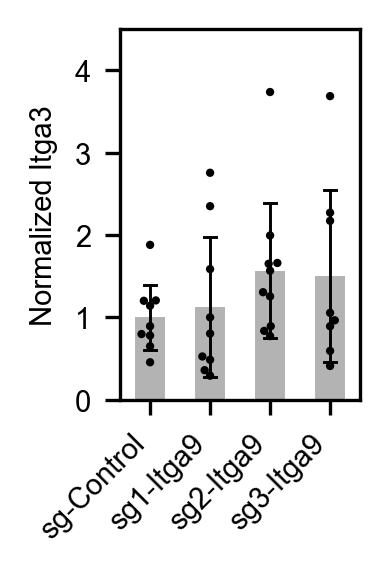

In [22]:
# Make plot for figure

fig_width, fig_height = 1.0, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Itga3-sg-Itga9-combined'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.15, 0.3, 0.8, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df1,
              x = 'sgRNA_id', y = 'normed_relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df1,
            x = 'sgRNA_id', y = 'normed_relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 4.5])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg1-Itga9', 'sg2-Itga9', 'sg3-Itga9']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel('Normalized Itga3')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [11]:
df2 = get_expression_data(df, 'Itga6 v1')

# Normalize expression level to the control group (make it 1)
control_relExp = df2[df2.sgRNA_id=='188'].relExp.mean()
df2['normed_relExp'] = df2.relExp / control_relExp

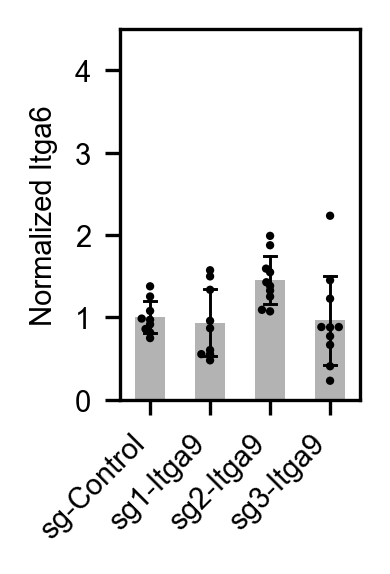

In [21]:
# Make plot for figure

fig_width, fig_height = 1.0, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Itga6-sg-Itga9-combined'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.15, 0.3, 0.8, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df2,
              x = 'sgRNA_id', y = 'normed_relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df2,
            x = 'sgRNA_id', y = 'normed_relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 4.5])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg1-Itga9', 'sg2-Itga9', 'sg3-Itga9']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel('Normalized Itga6')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [13]:
tukeyTest(df1.normed_relExp, df1.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   188    317   0.1281    0.9 -0.9625 1.2187  False
   188    318   0.5668 0.4825 -0.4963 1.6298  False
   188    319   0.5053 0.6081 -0.6189 1.6295  False
   317    318   0.4387 0.6632 -0.6243 1.5017  False
   317    319   0.3772 0.7783  -0.747 1.5014  False
   318    319  -0.0614    0.9 -1.1588  1.036  False
---------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.48248085 0.60811812 0.66315734 0.7783225  0.9       ]


In [14]:
for i in df1.sgRNA_id.unique():
    print(i, 'n =', len(df1[df1.sgRNA_id==i]))

188 n = 9
317 n = 9
318 n = 10
319 n = 8


In [15]:
tukeyTest(df2.normed_relExp, df2.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   188    317   -0.065    0.9 -0.5809   0.451  False
   188    318   0.4553 0.0875 -0.0476  0.9581  False
   188    319  -0.0374    0.9 -0.5403  0.4655  False
   317    318   0.5202 0.0404  0.0173  1.0231   True
   317    319   0.0276    0.9 -0.4753  0.5305  False
   318    319  -0.4926 0.0481 -0.9821 -0.0032   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.08754467 0.9        0.04037477 0.9        0.04805804]


In [16]:
for i in df2.sgRNA_id.unique():
    print(i, 'n =', len(df2[df2.sgRNA_id==i]))

188 n = 9
317 n = 9
318 n = 10
319 n = 10
